# Learning to Extract Pain Outcomes from Clinical Text without Labeled Data
## II: Generative Model



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
import os
import numba
import numpy as np
import matplotlib
import pandas as pd
#matplotlib.rcParams['figure.figsize'] = (18,6)

from snorkel import SnorkelSession
from snorkel.learning.disc_models.rnn import *
from snorkel.annotations import LabelAnnotator
from snorkel.annotations import load_gold_labels
from snorkel.models import candidate_subclass, Document, Sentence, Candidate, Span
from snorkel.learning import GenerativeModel
from extractlib.labelers import *

In [3]:
session = SnorkelSession()

try:
    PainLocation = candidate_subclass('PainLocation', ['pain', 'anatomy'])
except:
    pass

relation = PainLocationRelation(dict_root="../data/")
print "Labeling Functions n={}".format(len(relation.lfs))

Labeling Functions n=24


### Load Candidates and Gold Labels

In [4]:
train_cands = session.query(Candidate).filter(Candidate.split == 0).order_by(Candidate.id).all()
dev_cands   = session.query(Candidate).filter(Candidate.split == 1).order_by(Candidate.id).all()
test_cands  = session.query(Candidate).filter(Candidate.split == 2).order_by(Candidate.id).all()

L_gold_train = load_gold_labels(session, split=0, annotator_name='gold')
L_gold_dev   = load_gold_labels(session, split=1, annotator_name='gold')
L_gold_test  = load_gold_labels(session, split=2, annotator_name='gold')

print "Gold [TRAIN]", L_gold_train.size
print "Gold [DEV]  ", L_gold_dev.size
print "Gold [TEST] ", L_gold_test.size

Gold [TRAIN] 224
Gold [DEV]   63
Gold [TEST]  165


In [5]:
def get_doc_ids_by_split(session, split):
    '''
    Given a candidate set split, return all corresponding parent document ids
    '''
    q1 = session.query(Candidate.id).filter(Candidate.split == split).subquery()
    q2 = session.query(PainLocation.pain_id).filter(Candidate.id.in_(q1)).subquery()
    q3 = session.query(Span.sentence_id).filter(Span.id.in_(q2)).subquery()
    rows = session.query(Sentence.document_id).filter(Sentence.id.in_(q3)).distinct()
    #items = session.query(Document).filter(Document.id.in_(q4)).all()
    return rows


In [6]:
documents = session.query(Document).all()

In [7]:
print len(train_cands)
print len(dev_cands)
print len(test_cands)

candidates = train_cands + dev_cands + test_cands

225
63
168


### Applying Labeling Functions

In [8]:
from extractlib.relations.anatomy_pain import *
relations = AnatomyPainRelation(candidates, data_root="../data/")
lfs = relations.lfs
print len(lfs)

28


In [9]:
labeler = LabelAnnotator(lfs=lfs)

In [10]:
L_train = labeler.apply(split=0, parallelism=1)
L_dev   = labeler.apply_existing(split=1, parallelism=1)
L_test  = labeler.apply_existing(split=2, parallelism=1)

Clearing existing...
Running UDF...
[========================================] 100%

Clearing existing...
Running UDF...
[========================================] 100%

Clearing existing...
Running UDF...
[========================================] 100%



### Labeling Function Empirical Accuracy Statistics
Since we have labeled training data, we can examine empirical statistics for labeling function performance. Good labeling function design requires than any heuristic be correct with probablity better than random chance. 

In [11]:
L_train.lf_stats(session, labels=L_gold_train.toarray().ravel())

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_pro_re_nata,0,0.031111,0.008889,0.000000,0,0,0,7,1.000000
LF_negated,1,0.200000,0.120000,0.004444,0,0,1,44,0.977778
LF_hypothetical,2,0.182222,0.173333,0.000000,0,0,0,41,1.000000
LF_denies,3,0.111111,0.093333,0.004444,0,0,1,24,0.960000
LF_history_of,4,0.004444,0.000000,0.000000,0,0,0,1,1.000000
LF_long_term_history_of,5,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_compound_words,6,0.248889,0.106667,0.026667,52,4,0,0,0.928571
LF_pref_arg_attachment,7,0.311111,0.266667,0.022222,0,0,4,66,0.942857
LF_long_distance_attachment,8,0.160000,0.151111,0.000000,0,0,2,33,0.942857
LF_accept_header,9,0.044444,0.044444,0.004444,9,1,0,0,0.900000


## Training the Generative Model
Grid search for tuning.

In [17]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# use grid search to optimize the generative model
step_size_param     = ListParameter('step_size', [0.01 / L_train.shape[0]])
decay_param         = ListParameter('decay', [0.9])
epochs_param        = ListParameter('epochs', [200, 500])
reg_param           = ListParameter('reg_param', [0.001, 0.01])
reg_type            = ListParameter('reg_type', [1])
prior_param         = ListParameter('LF_acc_prior_weight_default', [1.0, 0.9, 0.8])

# search for the best model
param_grid = [step_size_param, decay_param, epochs_param, reg_param, reg_type, prior_param]
searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=5, lf_propensity=True)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, deps=set())

run_stats

Initialized RandomSearch search of size 3. Search space size = 4.
[1] Testing step_size = 4.44e-05, decay = 9.00e-01, epochs = 500, reg_param = 1.00e-02, reg_type = 1
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.808510638298
[GenerativeModel] Model saved as <GenerativeModel_0>.
[2] Testing step_size = 4.44e-05, decay = 9.00e-01, epochs = 200, reg_param = 1.00e-03, reg_type = 1
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.808510638298
[3] Testing step_size = 4.44e-05, decay = 9.00e-01, epochs = 500, reg_param = 1.00e-03, reg_type = 1
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.808510638298
[GenerativeModel] Model <GenerativeModel_0> loaded.
CPU times: user 24.5 s, sys: 86.8 ms, total: 24.5 s
Wall time: 24.5 s


,step_size,decay,epochs,reg_param,reg_type,Prec.,Rec.,F1
0,0.000044,0.9,500,0.010,1,0.826087,0.791667,0.808511
1,0.000044,0.9,200,0.001,1,0.826087,0.791667,0.808511
2,0.000044,0.9,500,0.001,1,0.826087,0.791667,0.808511


In [18]:
train_marginals = gen_model.marginals(L_train)

###  Labeling Function Accuracy Weights
These are the accuracy factor weights learned during training

In [25]:
lf_accs = []
for name,acc in zip([lf.__name__ for lf in lfs], gen_model.weights.lf_accuracy):
    lf_accs.append({"LF-NAME":name, "Acc. Factor Weight":acc})
pd.DataFrame(lf_accs)

,Acc. Factor Weight,LF-NAME
0,0.893885,LF_pro_re_nata
1,0.924052,LF_negated
2,0.921992,LF_hypothetical
3,0.908960,LF_denies
4,0.892476,LF_history_of
5,0.892203,LF_long_term_history_of
6,0.926660,LF_compound_words
7,0.945686,LF_pref_arg_attachment
8,0.920323,LF_long_distance_attachment
9,0.897945,LF_accept_header


array([<matplotlib.axes._subplots.AxesSubplot object at 0x123ba00d0>],
      dtype=object)

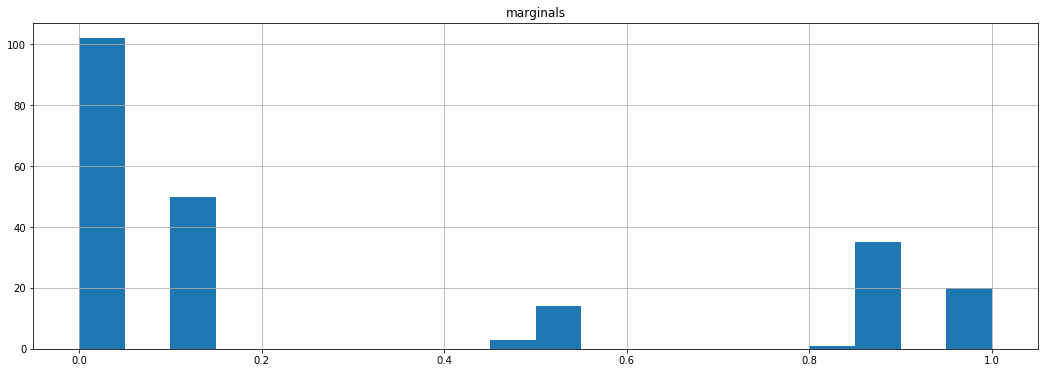

In [139]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 6))
df = pd.DataFrame(data=train_marginals, columns=['marginals'])
pd.DataFrame.hist(df,range=(0.0, 1.0),bins=20, ax=ax)

In [141]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def majority_vote(labels, gold_labels, title="Majority Vote"):
    
    mv = np.sum(labels,axis=1)
    mv[mv > 0] = 1
    mv[mv <= 0] = -1
    
    y_pred = np.ravel(mv)
    y_true = gold_labels.toarray()
    
    print "=" * 40
    print title
    print "=" * 40
    pos, neg = list(gold_labels).count(1),float(list(gold_labels).count(-1))
    print "pos/neg   {:.2f} {:.2f}".format(pos/(pos+neg), neg/(pos+neg))
    print "precision {:.2f}".format( 100 * precision_score(y_true, y_pred) )
    print "recall    {:.2f}".format( 100 * recall_score(y_true, y_pred) )
    print "f1        {:.2f}".format( 100 * f1_score(y_true, y_pred) )
    print "-" * 40

def score(marginals, gold_labels, title=""):
    y_pred = [1 if marginals[i] > 0.5 else -1 for i in range(0,len(marginals))]
    y_true = gold_labels.toarray()
    
    print "=" * 40
    print title
    print "=" * 40
    pos,neg = list(gold_labels).count(1),float(list(gold_labels).count(-1))
    print "pos/neg   {:.2f} {:.2f}".format(pos/(pos+neg), neg/(pos+neg))
    print "precision {:.2f}".format( 100 * precision_score(y_true, y_pred) )
    print "recall    {:.2f}".format( 100 * recall_score(y_true, y_pred) )
    print "f1        {:.2f}".format( 100 * f1_score(y_true, y_pred) )
    print "-" * 40

### Training Set: Majority Vote vs. Generative Model

In [142]:
def mv_vs_gen(marginals, L_mat, gold):
    majority_vote(L_mat, gold)
    score(marginals, gold, "Generative Model")
    
    
mv_vs_gen(train_marginals, L_train, L_gold_train)

Majority Vote
pos/neg   0.32 0.68
precision 91.07
recall    71.83
f1        80.31
----------------------------------------
Generative Model
pos/neg   0.32 0.68
precision 90.32
recall    78.87
f1        84.21
----------------------------------------


### Dev Set: Majority Vote

In [96]:
majority_vote(L_dev, L_gold_dev)

Majority Vote
pos/neg   0.38 0.62
precision 82.61
recall    79.17
f1        80.85
----------------------------------------


### Test Set: Majority Vote

In [97]:
majority_vote(L_test, L_gold_test)

Majority Vote
pos/neg   0.27 0.73
precision 86.84
recall    71.74
f1        78.57
----------------------------------------
